In [103]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet.diagnostics import cross_validation, performance_metrics


In [104]:
def wrangle(path, target="temp_max"):
        df = pd.read_csv(path)
        df['date'] = pd.to_datetime(df['date'])
        df['day_of_year'] = df['date'].dt.dayofyear

        df_prophet = df[['date', target]].rename(columns={'date': 'ds', target: 'y'})

        did_rain = [0 if i == 0 else 1 for i in df['precipitation_total']]
        df['did_rain'] = did_rain

        df.replace(-999.0000, np.nan, inplace=True)
        df_prophet.replace(-999.0000, np.nan, inplace=True)

        df.dropna(inplace=True)
        df_prophet.dropna(inplace=True)

        return df, df_prophet


In [109]:
df,df_prophet = wrangle("nasa_daily_weather.csv",target="dew_point_temp")
#model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
#model.fit(df_prophet)

In [106]:
params = {
    'changepoint_prior_scale': 0.05,        # moderate trend flexibility
    'changepoint_range': 0.95,              # detect changepoints over most of the history
    'seasonality_mode': 'multiplicative',   # weather variables often scale with level
    'seasonality_prior_scale': 5.0,         # allow moderate seasonal flexibility
    'holidays_prior_scale': 2.0,            # if using event/holiday effects
    'yearly_seasonality': 20,               # high-resolution annual pattern (Fourier order)
    'weekly_seasonality': 10,               # weekly cycle (for temp/solar flux)
    'daily_seasonality': False,             # rarely needed for daily aggregates
    'growth': 'linear'                      # weather doesn’t have capped logistic growth
}

model = Prophet(**params)
model.add_seasonality(name='semiannual', period=182.5, fourier_order=10)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_prophet)


19:43:28 - cmdstanpy - INFO - Chain [1] start processing
19:43:47 - cmdstanpy - INFO - Chain [1] done processing


In [107]:
# et_params = {
#     'growth': 'flat',                   # ET does not follow a saturating population-style curve
#     'changepoint_prior_scale': 0.02,      # fairly smooth long-term trend by default (low risk of overfitting)
#     'changepoint_range': 0.95,            # allow changepoints across most of 40-year history
#     'seasonality_mode': 'multiplicative', # seasonal amplitude often scales with level
#     'seasonality_prior_scale': 3.0,       # moderate flexibility for seasonal shape
#     'holidays_prior_scale': 1.0,          # only if you include events (e.g., irrigation schedules)
#     'yearly_seasonality': 25,             # high resolution annual cycle (many Fourier terms)
#     'weekly_seasonality': False,          # ET daily values rarely need weekly structure for long-term data
#     'daily_seasonality': False            # daily seasonality not needed for daily aggregated ET
# }

# model = Prophet(**et_params)

# # semi-annual (e.g., bimodal rainfall climates)
# model.add_seasonality(name='semiannual', period=182.5, fourier_order=8)

# # monthly / intra-annual variation
# model.add_seasonality(name='monthly', period=30.4375, fourier_order=6)
# model.fit(df_prophet)


19:43:53 - cmdstanpy - INFO - Chain [1] start processing
19:43:54 - cmdstanpy - INFO - Chain [1] done processing


In [110]:
df

,date,temp_max,temp_min,humidity_specific,pressure,precipitation_total,solar_radiation,wind_speed,evapotranspiration,soil_moisture_surface,dew_point_temp,lat,lon,day_of_year,did_rain
0,1984-01-01,19.55,8.60,6.21,100.37,0.08,3.7054,2.82,0.0000,0.20,6.71,29.987075,31.211806,1,1
1,1984-01-02,19.51,8.81,6.00,100.85,0.00,3.3499,2.24,0.0000,0.20,6.41,29.987075,31.211806,2,0
2,1984-01-03,19.69,7.56,6.24,100.89,0.06,3.5191,1.74,0.0000,0.20,7.05,29.987075,31.211806,3,1
3,1984-01-04,18.43,7.94,6.17,100.55,0.01,3.4500,1.86,0.0000,0.20,6.68,29.987075,31.211806,4,1
4,1984-01-05,18.31,6.57,5.72,100.46,0.00,3.5035,1.35,0.0000,0.20,5.72,29.987075,31.211806,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15275,2025-10-27,31.16,19.02,10.49,99.75,0.00,4.8694,1.74,0.0005,0.09,14.59,29.987075,31.211806,300,0
15276,2025-10-28,31.67,18.06,9.83,99.71,0.00,4.7926,1.97,0.0002,0.09,13.41,29.987075,31.211806,301,0
15277,2025-10-29,31.26,17.27,9.62,99.89,0.00,4.8221,2.67,0.0005,0.09,13.10,29.987075,31.211806,302,0
15278,2025-10-30,29.68,18.60,10.93,99.91,0.01,4.7609,3.32,0.0005,0.09,15.28,29.987075,31.211806,303,1


<Axes: >

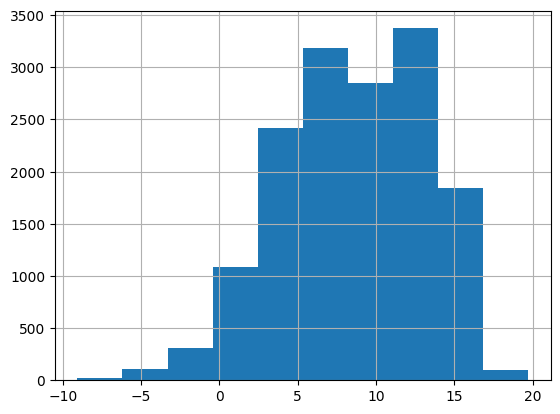

In [114]:
df['dew_point_temp'].hist()

In [112]:
# --- 4. Make Future Predictions ---
# Create a dataframe that extends into the future to our target date.
future = model.make_future_dataframe(periods=574) # Go past 2026-02-05
forecast = model.predict(future)

Forecast for 2025-09-15:
              ds       yhat  yhat_lower  yhat_upper
15284 2025-11-05  10.477504    6.951823    14.19772
------------------------------
Plotting the forecast...


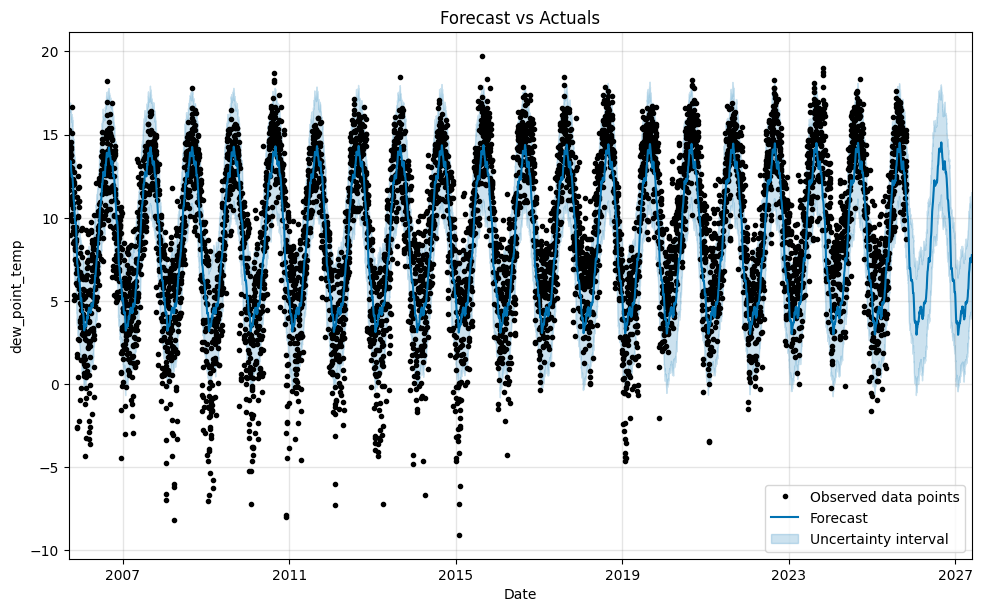

Plotting the model components...


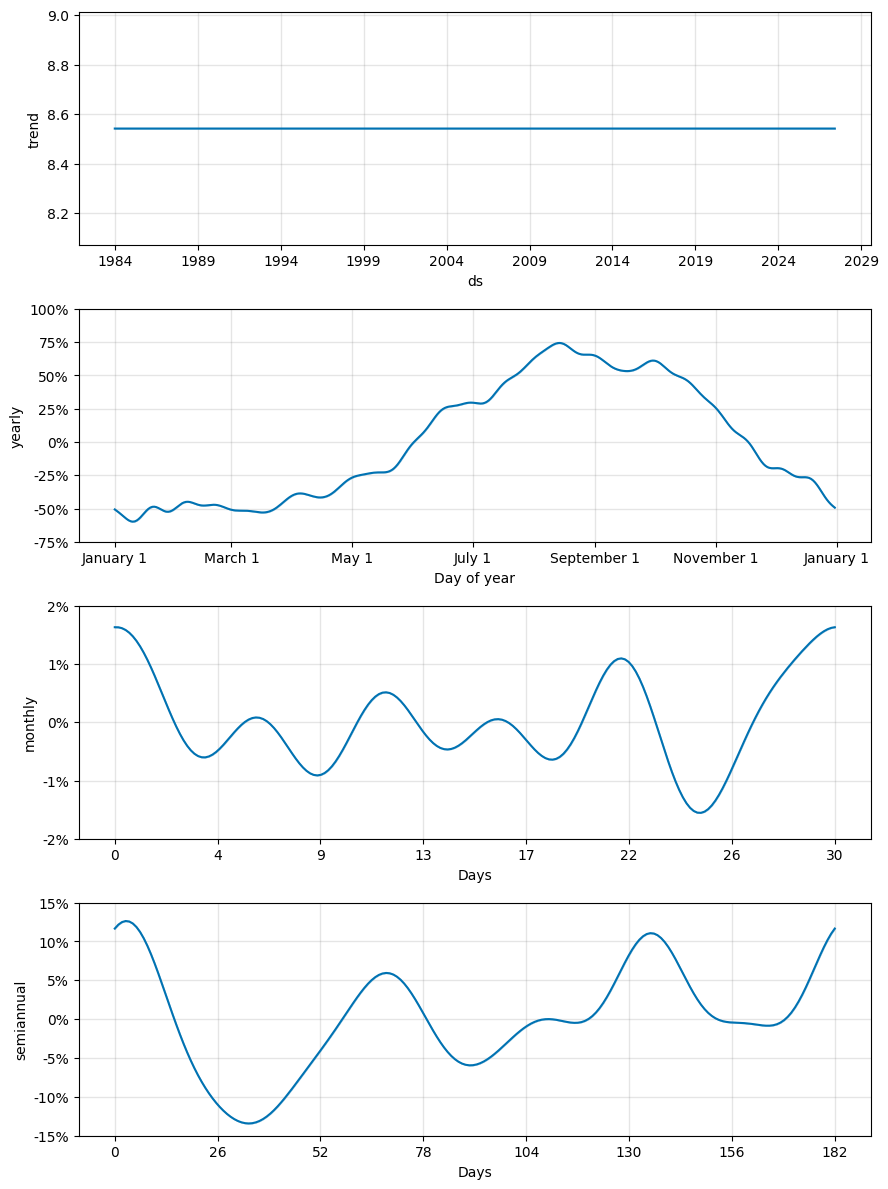

In [115]:

forecast_date = forecast[forecast['ds'] == '2025-11-05']
print(f"Forecast for 2025-09-15:")
print(forecast_date[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
# yhat: The predicted temperature.
# yhat_lower/yhat_upper: The uncertainty interval. The model is confident the true value will fall in this range.
print("-" * 30)


# B) Plot the entire forecast
# This is the best way to see how the model's prediction fits the historical data.
print("Plotting the forecast...")
fig1 = model.plot(forecast)
start, end = forecast['ds'].min(), forecast['ds'].max()
plt.xlim(end - 0.5 * (end-start) , end)
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('dew_point_temp')
plt.legend()
plt.show()

# C) Plot the model components
# This is the KEY to interpreting Prophet. It shows what patterns the model learned.
print("Plotting the model components...")
fig2 = model.plot_components(forecast)
plt.show()
# You will see:
# 1. Trend: The overall long-term direction of the temperature.
# 2. Yearly: The seasonal pattern learned by the model. This should look like a wave, peaking in summer and bottoming out in winter.

In [116]:
#Uncertainty (Confidence Interval) 
forecast['uncertainty'] = forecast['yhat_upper'] - forecast['yhat_lower']
print("Mean uncertainty:", forecast['uncertainty'].mean())


Mean uncertainty: 6.921466440229229


In [117]:
trend_strength = forecast['trend'].std()
seasonality_strength = forecast['weekly'].std() if 'weekly' in forecast else 0
print("Trend strength:", trend_strength)
print("Weekly seasonality strength:", seasonality_strength)


Trend strength: 9.521572953215322e-13
Weekly seasonality strength: 0


In [118]:
df_cv = cross_validation(
    model=model,
    initial='7300 days',   # first 20 years for training
    period='365 days',     # evaluate yearly
    horizon='180 days',    # predict 1 year ahead
    parallel="processes"   # use multiple cores for speed
)

df_p = performance_metrics(df_cv)

In [119]:
df_p.describe()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,163,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
mean,99 days 00:00:00,5.194152,2.264337,1.848496,0.232623,0.137428,0.160429,0.875504
std,47 days 04:45:21.352846324,1.202377,0.259502,0.193888,0.246430,0.035827,0.048232,0.043466
min,18 days 00:00:00,3.233278,1.798132,1.471897,0.099987,0.089187,0.102771,0.755051
25%,58 days 12:00:00,4.292473,2.071827,1.691868,0.121995,0.108469,0.125011,0.851010
50%,99 days 00:00:00,5.174762,2.274810,1.907973,0.147319,0.134645,0.153066,0.863636
75%,139 days 12:00:00,5.741693,2.396183,1.986920,0.197871,0.157282,0.174976,0.906566
max,180 days 00:00:00,8.986338,2.997722,2.308744,1.121392,0.230067,0.305517,0.957071
